# Introduction

Mes notebook ont été initialisés grâce à plusieurs sources fournies autour du concours [Kaggle](https://www.kaggle.com/c/home-credit-default-risk) sur le risque de défaut de paiement de crédit immobilier : données du crédit immobilier, carnets de notes des concurrents, fils de discussion impliquant l'hôte et les concurrents.

Alors que l'objectif des concurrents est d'obtenir le meilleure score (AUC) par tous les moyens, nous nous concentrerons plutôt sur la capacité à fournir des décisions interprétables, y compris la possibilité d'explorer le cas f'un client.

# Notebooks et tableau de bord
Ce projet comportent 7 Notebook différents :

* Projet7_AED : axé sur l'analyse exploratoire des données
* Projet7_kaggle_FE1_FE2 : axé sur l'ingénierie des caractéristiques
* Projet7_kaggle_FS: axé sur une première sélection des caractéristiques agnostiques du modèle
* Projet7_Modelisation_pycaret : se concentre sur l'évaluation de différent modéles
* Actuel : Projet7_Modelisation : se concentre sur l'amélioration des modéles selectionné précedament
* Projet7_Interprétation : se concentre sur l'interprétation du modèle

+ 2 fichiers python contenant le code du Dashboard et de l'api.

# **IMPORT DES DONNÉES**
Nous importons les données déjà pré-traitées :
* jointures
* aggrégations des variables numériques
* encodage fréquenciel normé des variables catégorielles
* variables sélectionnées sur la base:
    * du taux de remplissage
    * des corrélations
    * de la features importances d'un modèle (LightGBM)
* etc.

## Chargement des librairies

In [1]:
# import 'data stack' libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# increase the maximum number of columns to display
pd.set_option("display.max_columns", 1000)  # Maximum number of columns
pd.set_option("display.max_rows", 1000)  # Maximum number of columns

## Chargement des données

In [2]:
train = pd.read_csv('data/raw/m_train_small.csv')
test = pd.read_csv('data/raw/m_test_small.csv')

print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

Training set full shape:  (307511, 344)
Testing set full shape:  (48744, 343)


In [3]:
train.head()

,EXT_SOURCE_1,EXT_SOURCE_2,client_installments_AMT_PAYMENT_min_sum,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,bureau_DAYS_CREDIT_max,OWN_CAR_AGE,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_DAYS_CREDIT_ENDDATE_max,DAYS_ID_PUBLISH,bureau_AMT_CREDIT_MAX_OVERDUE_mean,previous_loans_CNT_PAYMENT_mean,client_cash_CNT_INSTALMENT_FUTURE_min_max,bureau_DAYS_ENDDATE_FACT_max,CODE_GENDER_F,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,previous_loans_NAME_CONTRACT_STATUS_Refused_count_norm,client_installments_DAYS_INSTALMENT_max_max,client_credit_AMT_RECIVABLE_mean_min,client_cash_SK_DPD_DEF_sum_max,REGION_POPULATION_RELATIVE,bureau_AMT_CREDIT_SUM_mean,bureau_DAYS_CREDIT_mean,bureau_AMT_CREDIT_SUM_max,bureau_DAYS_CREDIT_sum,previous_loans_AMT_DOWN_PAYMENT_max,client_cash_CNT_INSTALMENT_max_mean,client_cash_CNT_INSTALMENT_FUTURE_min_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_AMT_INSTALMENT_max_max,client_installments_AMT_PAYMENT_max_min,client_credit_CNT_DRAWINGS_CURRENT_max_max,previous_loans_RATE_DOWN_PAYMENT_sum,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_INSTALMENT_min_min,bureau_DAYS_CREDIT_UPDATE_max,bureau_AMT_CREDIT_SUM_DEBT_max,client_credit_AMT_DRAWINGS_CURRENT_mean_max,bureau_AMT_CREDIT_SUM_sum,LANDAREA_AVG,previous_loans_SELLERPLACE_AREA_max,previous_loans_PRODUCT_COMBINATION_Cash X-Sell: low_count_norm,previous_loans_NAME_YIELD_GROUP_high_count_norm,previous_loans_CNT_PAYMENT_max,bureau_DAYS_CREDIT_UPDATE_mean,previous_loans_DAYS_DECISION_mean,previous_loans_DAYS_LAST_DUE_1ST_VERSION_max,bureau_DAYS_CREDIT_ENDDATE_sum,NAME_EDUCATION_TYPE_Higher education,client_cash_MONTHS_BALANCE_sum_mean,AMT_INCOME_TOTAL,previous_loans_RATE_DOWN_PAYMENT_max,bureau_AMT_CREDIT_SUM_min,client_cash_CNT_INSTALMENT_max_max,previous_loans_CNT_PAYMENT_sum,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_DAYS_CREDIT_min,NAME_FAMILY_STATUS_Married,APARTMENTS_AVG,bureau_CREDIT_ACTIVE_Active_count,client_installments_AMT_INSTALMENT_min_mean,bureau_CREDIT_TYPE_Mortgage_count_norm,YEARS_BEGINEXPLUATATION_AVG,client_cash_MONTHS_BALANCE_max_mean,client_installments_NUM_INSTALMENT_NUMBER_max_mean,client_installments_NUM_INSTALMENT_VERSION_max_mean,previous_loans_DAYS_FIRST_DUE_min,client_installments_AMT_PAYMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_sum_max,previous_loans_NAME_YIELD_GROUP_low_action_count_norm,previous_loans_HOUR_APPR_PROCESS_START_mean,previous_loans_NAME_CONTRACT_STATUS_Approved_count_norm,previous_loans_DAYS_DECISION_sum,previous_loans_AMT_ANNUITY_mean,previous_loans_AMT_DOWN_PAYMENT_mean,previous_loans_RATE_DOWN_PAYMENT_mean,previous_loans_DAYS_DECISION_max,REGION_RATING_CLIENT,client_cash_MONTHS_BALANCE_sum_max,NAME_CONTRACT_TYPE_Cash loans,client_installments_AMT_PAYMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_max_min,client_installments_AMT_INSTALMENT_mean_mean,client_installments_DAYS_INSTALMENT_min_max,BASEMENTAREA_AVG,client_installments_AMT_PAYMENT_max_mean,previous_loans_PRODUCT_COMBINATION_Cash X-Sell: high_count_norm,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_mean,previous_loans_SELLERPLACE_AREA_min,client_installments_AMT_PAYMENT_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_norm_mean,client_installments_AMT_INSTALMENT_min_max,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_DAYS_CREDIT_ENDDATE_min,previous_loans_NAME_YIELD_GROUP_low_normal_count_norm,NONLIVINGAREA_AVG,previous_loans_NAME_PRODUCT_TYPE_walk-in_count_norm,client_installments_DAYS_ENTRY_PAYMENT_min_sum,DEF_60_CNT_SOCIAL_CIRCLE,previous_loans_AMT_ANNUITY_min,client_installments_AMT_INSTALMENT_mean_min,client_cash_CNT_INSTALMENT_mean_min,client_installments_AMT_INSTALMENT_sum_sum,client_installments_NUM_INSTALMENT_VERSION_sum_mean,previous_loans_DAYS_LAST_DUE_1ST_VERSION_min,client_installments_AMT_INSTALMENT_mean_max,client_credit_AMT_DRAWINGS_POS_CURRENT_sum_sum,previous_loans_AMT_GOODS_PRICE_min,client_cash_counts_

## Indexation sur 'SK_ID_CURR'

In [4]:
# Indexing on SK_ID_CURR, both for train and test sets
train = train.set_index('SK_ID_CURR')
test = test.set_index('SK_ID_CURR')

# **EXPLORATION**

## Valeurs dupliquées

In [5]:
# %%flake8  # checking PEP8 compliance

def contains_duplicates(dataframe):
    """This function checks the presence of duplicates rows in a dataframe."""

    mask = dataframe.duplicated(keep='first')
    nb_duplicates = len(dataframe[mask])

    if nb_duplicates == 0:
        return False

    else:
        return True

In [6]:
contains_duplicates(train)

False

## Valeurs manquantes

In [7]:
def global_filling_rate(dataframe):
    """Compute and displays global filling rate of a DataFrame"""

    # get the numbers of rows and columns in the dataframe
    nb_rows, nb_columns = dataframe.shape
    print("DataFrame has {} rows and {} columns.".format(nb_rows, nb_columns))

    # get the number of non-Nan data in the dataframe
    nb_data = dataframe.count().sum()

    # computing the filling rate
    filling_rate = nb_data / (nb_rows * nb_columns)
    missing_rate = 1 - filling_rate

    # computing the total missing values
    missing_values = (nb_rows * nb_columns) - nb_data

    # display global results
    print("")
    print("Global filling rate of the DataFrame: {:.2%}".format(filling_rate))
    print("Missing values in the DataFrame: {} ({:.2%})"
          .format(missing_values, missing_rate))

    # compute number of rows with missing values
    mask = dataframe.isnull().any(axis=1)
    rows_w_missing_values = len(dataframe[mask])
    rows_w_missing_values_percentage = rows_w_missing_values / nb_rows

    # display results
    print("")
    print("Number of rows with missing values: {} ({:.2%})"
          .format(rows_w_missing_values, rows_w_missing_values_percentage))

    # compute number of columns with missing values
    mask = dataframe.isnull().any(axis=0)
    cols_w_missing_values = len(dataframe[dataframe.columns[mask]].columns)
    cols_w_missing_values_percentage = cols_w_missing_values / nb_columns

    # display results
    print("Number of columns with missing values: {} ({:.2%})"
          .format(cols_w_missing_values, cols_w_missing_values_percentage))

In [8]:
global_filling_rate(train)

DataFrame has 307511 rows and 343 columns.

Global filling rate of the DataFrame: 80.67%
Missing values in the DataFrame: 20387003 (19.33%)

Number of rows with missing values: 306625 (99.71%)
Number of columns with missing values: 307 (89.50%)


In [9]:
def columns_filling_rate(dataframe, columns='all', missing_only=False):
    """Calculate and displays the filling rate for
    a particular column in a pd.DataFrame."""
    
    # Importations
    import pandas as pd
    import numpy as np
    
    # If 'feature' is not specified
    if columns == 'all':
        columns = dataframe.columns
        
    
    # initialization of the results DataFrame
    results = pd.DataFrame(columns=['nb_values', 'missing_values', 'filling_rate'])
        
    # for each feature
    for column in columns:

        # Count of the values on each column
        values_count = dataframe[column].count()
        
        # Computing missing values
        nb_rows = dataframe.shape[0]
        missing_values = nb_rows - values_count

        # Computing filling rates
        filling_rate = values_count / nb_rows
        if missing_only and missing_values == 0:
            filling_rate = np.nan
        
        # Adding a row in the results' dataframe
        results.loc[column] = [values_count, missing_values, filling_rate]

    # Sorting the features by number of missing_values
    results = results.dropna(subset=['filling_rate'])
    results = results.sort_values('filling_rate')
    
    if results.empty == False:
        return results
    else:
        print("No missing value.")

In [10]:
global_filling_rate(train)

DataFrame has 307511 rows and 343 columns.

Global filling rate of the DataFrame: 80.67%
Missing values in the DataFrame: 20387003 (19.33%)

Number of rows with missing values: 306625 (99.71%)
Number of columns with missing values: 307 (89.50%)


In [11]:
# Dropping the columns where filling rate < 80%
# ----------------------------------------------

def get_features_under_filling_threshold(features_df, threshold=0.9):
    # computing the filling rates
    col_fillings = columns_filling_rate(features_df, columns='all', missing_only=True)

    # creating a mask for filling rate < threshold
    mask = col_fillings['filling_rate'] < threshold

    # getting the list of features
    set_cols_to_delete = set(col_fillings[mask].index)
    return set_cols_to_delete


set_cols_to_delete_train = get_features_under_filling_threshold(train, threshold=0.9)
set_cols_to_delete_test = get_features_under_filling_threshold(train, threshold=0.9)
set_cols_to_delete = set_cols_to_delete_train.union(set_cols_to_delete_test)

# deleting the rows both in train set and test set
train = train.drop(columns=set_cols_to_delete)
test = test.drop(columns=set_cols_to_delete)

global_filling_rate(train)
print(train.shape)
print(test.shape)

DataFrame has 307511 rows and 218 columns.

Global filling rate of the DataFrame: 95.60%
Missing values in the DataFrame: 2951272 (4.40%)

Number of rows with missing values: 21836 (7.10%)
Number of columns with missing values: 182 (83.49%)
(307511, 218)
(48744, 217)


In [12]:
columns_filling_rate(train, columns='all', missing_only=True)

,nb_values,missing_values,filling_rate
client_cash_CNT_INSTALMENT_max_max,289420.0,18091.0,0.941170
client_cash_CNT_INSTALMENT_min_min,289420.0,18091.0,0.941170
client_cash_CNT_INSTALMENT_FUTURE_min_max,289420.0,18091.0,0.941170
client_cash_CNT_INSTALMENT_mean_min,289420.0,18091.0,0.941170
client_cash_CNT_INSTALMENT_min_mean,289420.0,18091.0,0.941170
client_cash_CNT_INSTALMENT_max_mean,289420.0,18091.0,0.941170
client_cash_CNT_INSTALMENT_FUTURE_min_mean,289420.0,18091.0,0.941170
client_cash_MONTHS_BALANCE_max_mean,289444.0,18067.0,0.941248
client_cash_NAME_CONTRACT_STATUS_Active_count_max,289444.0,18067.0,0.941248
client_cash_NAME_CONTRACT_STATUS_Active_count_min,289444.0,18067.0,0.941248


In [13]:
def filtering_rows(df, threshold=0.9):

    import seaborn as sns

    # Compute the filling rates of each row
    filling_rate_rows = df.notna().mean(axis=1)

    # Display the histogram and KDE of the distribution
    ax = sns.distplot(filling_rate_rows, kde=False)

    # Create a mask for rows where filling rate is above threhold
    mask = filling_rate_rows > threshold

    # Filtering the DataFrame
    filtered_df = df[mask]

    # Display the results
    print('Threshold for filling rate:', threshold)
    print('Rows under threshold:', len(df) - len(filtered_df))
    print('Rows above threshold:', len(filtered_df))

    # Return the filtered DataFrame
    return filtered_df

Threshold for filling rate: 0.9
Rows under threshold: 19483
Rows above threshold: 288028


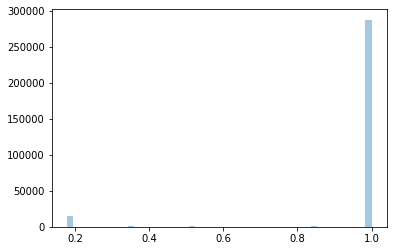

In [14]:
train = filtering_rows(train, threshold=0.9)

## Typage des données

In [15]:
train.describe()

,EXT_SOURCE_2,client_installments_AMT_PAYMENT_min_sum,DAYS_BIRTH,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_ID_PUBLISH,previous_loans_CNT_PAYMENT_mean,client_cash_CNT_INSTALMENT_FUTURE_min_max,CODE_GENDER_F,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,previous_loans_NAME_CONTRACT_STATUS_Refused_count_norm,client_installments_DAYS_INSTALMENT_max_max,client_cash_SK_DPD_DEF_sum_max,REGION_POPULATION_RELATIVE,client_cash_CNT_INSTALMENT_max_mean,client_cash_CNT_INSTALMENT_FUTURE_min_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_AMT_INSTALMENT_max_max,client_installments_AMT_PAYMENT_max_min,previous_loans_RATE_DOWN_PAYMENT_sum,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_INSTALMENT_min_min,previous_loans_SELLERPLACE_AREA_max,previous_loans_PRODUCT_COMBINATION_Cash X-Sell: low_count_norm,previous_loans_NAME_YIELD_GROUP_high_count_norm,previous_loans_CNT_PAYMENT_max,previous_loans_DAYS_DECISION_mean,previous_loans_DAYS_LAST_DUE_1ST_VERSION_max,NAME_EDUCATION_TYPE_Higher education,client_cash_MONTHS_BALANCE_sum_mean,AMT_INCOME_TOTAL,client_cash_CNT_INSTALMENT_max_max,previous_loans_CNT_PAYMENT_sum,NAME_FAMILY_STATUS_Married,client_installments_AMT_INSTALMENT_min_mean,client_cash_MONTHS_BALANCE_max_mean,client_installments_NUM_INSTALMENT_NUMBER_max_mean,client_installments_NUM_INSTALMENT_VERSION_max_mean,previous_loans_DAYS_FIRST_DUE_min,client_installments_AMT_PAYMENT_mean_sum,client_installments_DAYS_ENTRY_PAYMENT_sum_max,previous_loans_NAME_YIELD_GROUP_low_action_count_norm,previous_loans_HOUR_APPR_PROCESS_START_mean,previous_loans_NAME_CONTRACT_STATUS_Approved_count_norm,previous_loans_DAYS_DECISION_sum,previous_loans_AMT_ANNUITY_mean,previous_loans_DAYS_DECISION_max,REGION_RATING_CLIENT,client_cash_MONTHS_BALANCE_sum_max,NAME_CONTRACT_TYPE_Cash loans,client_installments_AMT_PAYMENT_sum_min,client_installments_DAYS_ENTRY_PAYMENT_max_min,client_installments_AMT_INSTALMENT_mean_mean,client_installments_DAYS_INSTALMENT_min_max,client_installments_AMT_PAYMENT_max_mean,previous_loans_PRODUCT_COMBINATION_Cash X-Sell: high_count_norm,previous_loans_SELLERPLACE_AREA_min,client_installments_AMT_PAYMENT_max_sum,client_cash_NAME_CONTRACT_STATUS_Active_count_norm_mean,client_installments_AMT_INSTALMENT_min_max,previous_loans_NAME_YIELD_GROUP_low_normal_count_norm,previous_loans_NAME_PRODUCT_TYPE_walk-in_count_norm,client_installments_DAYS_ENTRY_PAYMENT_min_sum,DEF_60_CNT_SOCIAL_CIRCLE,previous_loans_AMT_ANNUITY_min,client_installments_AMT_INSTALMENT_mean_min,client_cash_CNT_INSTALMENT_mean_min,client_installments_AMT_INSTALMENT_sum_sum,client_installments_NUM_INSTALMENT_VERSION_sum_mean,previous_loans_DAYS_LAST_DUE_1ST_VERSION_min,client_installments_AMT_INSTALMENT_mean_max,previous_loans_AMT_GOODS_PRICE_min,client_cash_counts_mean,client_cash_SK_DPD_max_sum,previous_loans_AMT_ANNUITY_max,previous_loans_DAYS_LAST_DUE_sum,client_installments_AMT_INSTALMENT_min_sum,FLAG_DOCUMENT_3,previous_loans_NAME_CLIENT_TYPE_Refreshed_count_norm,client_cash_CNT_INSTALMENT_FUTURE_min_sum,client_cash_CNT_INSTALMENT_min_mean,client_cash_NAME_CONTRACT_STATUS_Completed_count_norm_mean,HOUR_APPR_PROCESS_START,previous_loans_NAME_PRODUCT_TYPE_XNA_count_norm,previous_loans_NAME_TYPE_SUITE_Unaccompanied_count_norm,previous_loans_NAME_PORTFOLIO_POS_count_norm,previous_loans_DAYS_TERMINATION_min,previous_loans_AMT_APPLICATION_max,DEF_30_CNT_SOCIAL_CIRCLE,previous_loans_PRODUCT_COMBINATION_Cash Street: low_count_norm,previous_loans_DAYS_FIRST_DUE_mean,client_cash_CNT_INSTALMENT_sum_min,previous_loans_PRODUCT_COMBINATION_POS industry with interest_count_norm,previous_loans_AMT_CREDIT_min,client_installments_NUM_INSTALMENT_VERSION_sum_sum,NAME_INCOME_TYPE_Working,client_cash_counts_sum,REG_CITY_NOT_LIVE_CITY,previous_loans_NAME_YIELD_GROUP_middle_count_norm,FLAG_DOCUMENT_18,previous_loans_CODE_REJECT_REASON_HC_count_norm,previous_loans_NAME_CLIENT_TYPE_New_count_norm,NAME_EDUCATION_TYPE_Secondary / secondary special,previous_lo

In [16]:
train.dtypes

EXT_SOURCE_2                                                                    float64
client_installments_AMT_PAYMENT_min_sum                                         float64
DAYS_BIRTH                                                                        int64
AMT_CREDIT                                                                      float64
AMT_ANNUITY                                                                     float64
DAYS_EMPLOYED                                                                     int64
DAYS_ID_PUBLISH                                                                   int64
previous_loans_CNT_PAYMENT_mean                                                 float64
client_cash_CNT_INSTALMENT_FUTURE_min_max                                       float64
CODE_GENDER_F                                                                     int64
DAYS_REGISTRATION                                                               float64
DAYS_LAST_PHONE_CHANGE          

## Équilibre des classes

In [17]:
def categorical_distribution(dataframe, feature, ordinal=False):
    """Function plotting the bar-plot and pie-plot (as subplots) for 
    a distribution of categorical features."""
    
    # importing libraries
    import matplotlib.pyplot as plt

    # filtering non-null data for the feature
    mask = dataframe[feature].notnull()
    data_view = dataframe[mask]
    
    # Setting the data to plot
    x=data_view[feature]
    
    # Set frequencies and labels, sorting by index
    if ordinal==True:
        labels = list(x.value_counts().sort_index().index.astype(str))
        frequencies = x.value_counts().sort_index()
    else:
        labels = list(x.value_counts().sort_values(ascending=False).index.astype(str))
        frequencies = x.value_counts().sort_values(ascending=False)
    
    # Graphical properties of the main figure
    fig = plt.figure(figsize=(14, 6))
    
    plt.suptitle("Empiric statistical distribution: " + feature, fontsize=25)
    
    # Main graphical properties of the first subplot (histogram)
    ax1 = plt.subplot(121)
    ax1.set_xlabel("Values", fontsize=20)
    ax1.set_ylabel("Frequencies", fontsize=20)
    ax1.set_xticklabels(labels, rotation='45', horizontalalignment="right")

    # Main graphical properties of the second subplot (pieplot)
    ax2 = plt.subplot(122)
    ax2.set_xlabel("Relative frequencies", fontsize=20)
    
    # plotting the plots
    ax1.bar(labels, frequencies)
    ax2.pie(frequencies,
            autopct='%1.2f%%',
            shadow=True,
              )
    
    ax2.legend(labels)
    plt.show()
    return fig

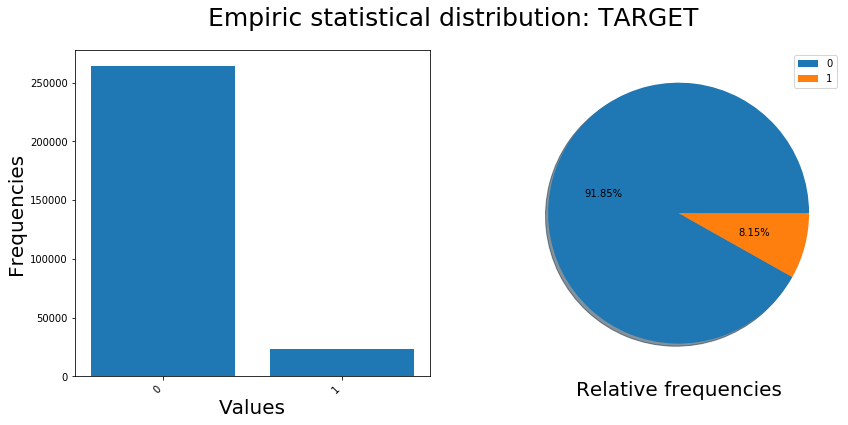

In [18]:
fig = categorical_distribution(
    train,
    'TARGET'
)

fig.savefig('plots/imba_classes.png')

## Enregistrer les données prétraitées

In [1]:
train.to_csv('data/cleaned/data_train_featured.csv')

NameError: name 'train' is not defined

# **PRÉPARATION**

In [2]:
import pandas as pd

train = pd.read_csv('data/cleaned/data_train_featured.csv', index_col='SK_ID_CURR')

In [3]:
# Set random integer (seed) - 891
from random import randrange
seed = randrange(1000)
print("Seed value: ", seed)

Seed value:  125


## **Séparation** des jeux d'apprentissage (X_fit) et d'évaluation (X_eval)

In [4]:
from sklearn.model_selection import train_test_split

# Splitting features and targets
X = train.drop(columns='TARGET')
y = train['TARGET']

# Splitting into fitting set and evaluation set
(X_fit, X_eval, y_fit, y_eval) = train_test_split(
        X,
        y,
        train_size=0.8,
        test_size=0.2,
        random_state=seed,
        stratify=y, # because classes are imbalanced
    )

## **Imputations**

In [5]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(X_fit)

feature_names = X_fit.columns
index_X_fit = X_fit.index
index_X_eval = X_eval.index

X_fit = pd.DataFrame(imp_mean.transform(X_fit), columns=feature_names, index=index_X_fit)
X_eval = pd.DataFrame(imp_mean.transform(X_eval), columns=feature_names, index=index_X_eval)

## **Équilibrage des classes** du jeu d'entraînement

### **Sous-échantillonnage** (*downsampling*) de la classe majoritaire

In [6]:
def downsampling(features_matrix, target_vector):

    from sklearn.utils import resample
    
    # Getting the majority class
    majority_class = target_vector.value_counts(sort=True).index[0]
    
    # Create a mask for the majority class
    mask = (target_vector == majority_class)
    
    # Get the subset of the majority and minority classes
    maj_df = features_matrix[mask]
    min_df = features_matrix[~mask]
    
    # Downsampling the majority class
    features_matrix_maj_downsampled = resample(
        maj_df,
        replace=False,
        n_samples=len(min_df),
        random_state=seed,
    )
    
    # Get the index of the downsampled rows
    list_index = features_matrix_maj_downsampled.index
    mask2 = (target_vector.index.isin(list_index))
    target_vector_maj_downsampled = target_vector[mask2]
    
    
    # Concatenation of the DataFrames for the 2 classes
    features_matrix_downsampled = pd.concat([min_df, features_matrix_maj_downsampled])
    target_vector_downsampled = pd.concat([target_vector[~mask], target_vector_maj_downsampled])

    return (features_matrix_downsampled, target_vector_downsampled)

(X_fit_balanced, y_fit_balanced) = downsampling(
    features_matrix=X_fit,
    target_vector=y_fit,
)

y_fit_balanced.value_counts()

1    18787
0    18787
Name: TARGET, dtype: int64

## **Échantillonnage** pour la sélection du modèle

In [7]:
# Sampling the features_matrix
X_fit_sample = X_fit_balanced.sample(n=1000, random_state=seed)
    
# Get the indexes to sample target_vector
list_index = X_fit_sample.index
mask = (y_fit_balanced.index.isin(list_index))
y_fit_sample = y_fit_balanced[mask]

# print results
len(y_fit_sample)

1000

# **SÉLECTION DU PIPE-LINE** (*hyperopt*)

$EI(x) =  \frac{l(x)}{g(x)}$
* EI(x): Expected Improvement
* l(x): probability of being in the 1st group (eg best 20%)
* g(x): probability of being in the 2nd group (others)

In [8]:
!pip install hyperopt

In [241]:
from hyperopt import hp

# Initializing the search space
space = {}

## Définition de l'espace des **pré-traitements**

In [242]:
# Initializing the search space for preprocessing steps
space['preprocessing_steps'] = {
    'scale':       hp.choice('scale', [True, False]),
    'normalize':       hp.choice('normalize', [True, False]),
}

In [243]:
# Define the preprocessing steps
def preprocess_steps(params, X_):
    from sklearn.preprocessing import Normalizer
    from sklearn.preprocessing import StandardScaler
    
    # Display some information…
    print('Preprocessing in progress…')
    
    if 'normalize' in params['preprocessing_steps']:
        if params['preprocessing_steps']['normalize'] == True:
            X_ = Normalizer().fit_transform(X_)
        
    if 'scale' in params['preprocessing_steps']:
        if params['preprocessing_steps']['scale'] == True:
            X_ = StandardScaler().fit_transform(X_)

    return X_

## Définition de l'espace des **modèles**


Nous allons dans cette partie chercher a améliorer le score obtenue sur les modéles Pycaret en ajoutant certain modéles non disponible.

In [244]:
# Loading libraries
from hyperopt import hp

# Initalisation of the spaces of research for models
models_spaces = {}

In [245]:
!pip install lightgbm

In [246]:
from sklearn.naive_bayes import GaussianNB

### NAIVE BAYES
models_spaces['naive_bayes'] = {
    'model': GaussianNB,
}

In [247]:
from lightgbm import LGBMClassifier 

### lightgbm
models_spaces['liggbm'] = {
    'model': LGBMClassifier,
    'n_estimators': hp.choice('liggbm_n_estimators', np.arange(10, 810, 50, dtype=int)),
    'class_weight': hp.choice('liggbm_class_weight', ['balanced']),
    'max_depth': hp.choice('liggbm_max_depth', np.arange(1, 30, dtype=int)),
    'num_leaves': hp.choice('liggbm_num_leaves', np.arange(4, 101, 4, dtype=int)),
    'boosting_type': hp.choice('liggbm_boosting_type', ['gbdt', 'dart', 'goss']),
    'learning_rate': hp.loguniform('liggbm_learning_rate', np.log(0.01), np.log(0.2))
}

In [248]:
from sklearn.linear_model import Ridge
"""
Does not have a predict proba method because its a linear model, can't be use with hyperopt
### Ridge
models_spaces['ridge'] = { 
    'model':        Ridge,
    'alpha': hp.uniform('alpha', 0.0, 1.0),
    'fit_intercept' : hp.choice('ridge_fit_intercept', [True, False]),
    'max_iter' :      hp.choice('ridge_max_iter', range(100,1000)),
    'tol' :           hp.uniform('ridge_tol', 0.00001, 0.0001),
    'solver' :        hp.choice('ridge_solver', ['saga']),
}"""

"\n\n### Ridge\nmodels_spaces['ridge'] = { \n    'model':        Ridge,\n    'alpha': hp.uniform('alpha', 0.0, 1.0),\n    'fit_intercept' : hp.choice('ridge_fit_intercept', [True, False]),\n    'max_iter' :      hp.choice('ridge_max_iter', range(100,1000)),\n    'tol' :           hp.uniform('ridge_tol', 0.00001, 0.0001),\n    'solver' :        hp.choice('ridge_solver', ['saga']),\n}"

In [249]:
Ridge

sklearn.linear_model._ridge.Ridge

In [250]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

### LDA
models_spaces['LDA'] = { 
    'model':        LDA,
    'solver': hp.choice('lda_solver', ['svd', 'lsqr', 'eigen']),
}

In [251]:
"""from sklearn.ensemble.forest import RandomForestClassifier

### RANDOM FOREST
models_spaces['rf'] = { 
    'model':        RandomForestClassifier,
    'max_depth':    hp.choice('rf_max_depth', range(1,20)),
    'max_features': hp.choice('rf_max_features', range(1,3)),
    'n_estimators': hp.choice('rf_n_estimators', range(10,50)),
    'criterion':    hp.choice('rf_criterion', ["gini", "entropy"]),
}"""

'from sklearn.ensemble.forest import RandomForestClassifier\n\n### RANDOM FOREST\nmodels_spaces[\'rf\'] = { \n    \'model\':        RandomForestClassifier,\n    \'max_depth\':    hp.choice(\'rf_max_depth\', range(1,20)),\n    \'max_features\': hp.choice(\'rf_max_features\', range(1,3)),\n    \'n_estimators\': hp.choice(\'rf_n_estimators\', range(10,50)),\n    \'criterion\':    hp.choice(\'rf_criterion\', ["gini", "entropy"]),\n}'

In [252]:
"""from sklearn.linear_model import LogisticRegression

### LOGISTIC REGRESSION
models_spaces['logit'] = { 
    'model':          LogisticRegression,
    'warm_start' :    hp.choice('logit_warm_start', [True, False]),
    'fit_intercept' : hp.choice('logit_fit_intercept', [True, False]),
    'tol' :           hp.uniform('logit_tol', 0.00001, 0.0001),
    'C' :             hp.uniform('logit_C', 0.05, 3),
    'solver' :        hp.choice('logit_solver', ['newton-cg', 'lbfgs', 'liblinear']),
    'max_iter' :      hp.choice('logit_max_iter', range(100,1000)),
    'multi_class' :   'auto',
    'class_weight' :  'balanced',
}"""

"from sklearn.linear_model import LogisticRegression\n\n### LOGISTIC REGRESSION\nmodels_spaces['logit'] = { \n    'model':          LogisticRegression,\n    'warm_start' :    hp.choice('logit_warm_start', [True, False]),\n    'fit_intercept' : hp.choice('logit_fit_intercept', [True, False]),\n    'tol' :           hp.uniform('logit_tol', 0.00001, 0.0001),\n    'C' :             hp.uniform('logit_C', 0.05, 3),\n    'solver' :        hp.choice('logit_solver', ['newton-cg', 'lbfgs', 'liblinear']),\n    'max_iter' :      hp.choice('logit_max_iter', range(100,1000)),\n    'multi_class' :   'auto',\n    'class_weight' :  'balanced',\n}"

In [253]:
# Creating the whole space from all the model-specific spaces
space['models_spaces'] = hp.choice(
        'models_spaces',
        [ models_spaces[key] for key in models_spaces ]
    )

## Définition de la **métrique de sélection**


### **Métrique** personnalisée

* $gain = TP·TP\_value + TN·TN\_value + FP·FP\_value + FN·FN\_value$
* $best = (TN+FP)·TN\_value + (TP+FN)·TP\_value$
* $baseline = (TN+FP)·TN\_value + (TP+FN)·FN\_value$

=> $score = \frac{gain - baseline}{best - baseline} ∈ [0 ; 1]$

=> $model\_score = \underset{threshold \in [0;1]}{\text{max}} [score] ∈ [0 ; 1]$

In [254]:
import numpy as np
from sklearn.metrics import confusion_matrix

def custom_score(y_true, y_pred):
    # Relative loss and gains for each case
    TP_value = 0       # expected default
    FP_value = 0       # unexpected not-default (real: not-default, predicted: default)
    FN_value = -10     # unexpected default (real: default(P), predicted: not-default(N))
    TN_value = 1       # expected not-default

    # Confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()

    # Full negative and positive cases
    N = TN + FP # total true not-default
    P = TP + FN # total true default

    gain = TP*TP_value + TN*TN_value + FP*FP_value + FN*FN_value
    best = N*TN_value + P*TP_value
    # worst = P*FN_value + N*FP_value
    # baseline : strategy : “most_frequent” (N)
    baseline = N*TN_value + P*FN_value
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain - baseline) / (best - baseline)
    return score


def predict_threshold(model, X, threshold=0.5):
    predictions = model.predict_proba(X)
    mask = (predictions[:, 1] > threshold)
    return mask.astype(int)


def custom_scorer(model, X, y_true):
    scores = []
    for threshold in np.linspace(0, 1, num=101):
    #threshold = 0.5
        y_pred = predict_threshold(model, X, threshold=threshold)
        score = custom_score(y_true, y_pred)
        scores.append(score)
    # print(max(scores))
    return max(scores)
    # return score

### **Générateur de plis**

In [255]:
from sklearn.model_selection import KFold

# Define the cross-validation generator
cv_inner = KFold(
    n_splits=5, # number of folds (default=5)
    shuffle=True, # shuffle the data before splitting into batche
    random_state=seed, # seeding the random number generator for shuffling
)

### **Validation croisée**

In [256]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

# Define the loss metric for the model
def get_acc_status(clf, X_, y):
    
    # Display some information…
    print('Cross-validation in progress…')
    
    # Proceed to the cross-validation
    # cv_result is a dict : test_score, train_score, fit_time, score_time, estimator
    cv_results = cross_validate(
        clf,
        X_,
        y,
        cv=cv_inner,
        scoring=custom_scorer,
    )
    
    loss = -cv_results['test_score'].mean()
    
    # displays results
    print("Loss of the model:", loss)
    
    return {
        'loss': loss,
        'loss_std': cv_results['test_score'].std(),
        'status': STATUS_OK,
    }

## Définition de la "**fonction objectif**" d'*Hyperopt*

In [257]:
# Define th objective function
def obj_fnc(params):
        # Display the set of parameters currently evaluated
        print('Parameters tested:', params)
        
        # proceed to preprocessing
        X_fit_ = preprocess_steps(params, X_fit[:])
        
        # get all parameters, except the model
        parameters = params['models_spaces'].copy()
        del parameters['model']
        
        # instanciation of the classifier model with parameters
        clf = params['models_spaces']['model'](**parameters)
        
        # return loss and status
        return(get_acc_status(clf, X_fit_, y_fit))

## Définition de la **recherche**

In [258]:
# load libraries
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK, space_eval
import pickle

def run_trials():

    trials_step = 1  # how many additional trials to do after loading saved trials. 1 = save after iteration
    initial_evals = 1  # initial max_trials. put something small to not have to wait

    try:  # try to load an already saved trials object, and increase the max
        hypopt_trials = pickle.load(open("hp_trials/trials.hyperopt", "rb"))
        print("Found saved Trials! Loading...")
        max_evals = len(hypopt_trials.trials) + trials_step
        print("Rerunning from {} trials.".format(len(hypopt_trials.trials)))
        
    except:  # create a new trials object and start searching
        print("Unable to load previous trials...")
        hypopt_trials = Trials()
        max_evals = initial_evals

    # Optimisation accross the search space
    global best_params
    best_params = fmin(
        obj_fnc,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=hypopt_trials
    )

    # save the trials object
    with open("hp_trials/trials.hyperopt", mode="wb") as f:
        pickle.dump(hypopt_trials, f)
        
    # get the best_params and save them
    best_params = space_eval(space, best_params)
    with open("hp_trials/best_params.hyperopt", mode="wb") as f:
        pickle.dump(best_params, f)
    
    # print the main results
    print(
        #"\nAlgo:", best_params['models_spaces']['model'],
        "\nBest loss:", hypopt_trials.best_trial['result']['loss'],
        #"\nPreprocessing:", best_params['preprocessing_steps'],
        #"\nModel params:", best_params['models_spaces'],
        "\n----------------------",
    )

## Exécution de la **recherche** (persistante)

In [240]:
!pip install keyboard

import threading as th
import keyboard

# loop indefinitely and stop whenever you like (pressing ENTER)
keep_going = True
def key_capture_thread():
    global keep_going
    # Blocks until you press 'ESC'.
    keyboard.wait('esc')
    keep_going = False
    print('\nINTERRUPTING… Please wait until shut down.')

def trials_loop():
    th.Thread(target=key_capture_thread, args=(), name='key_capture_thread', daemon=True).start()
    while keep_going:
        print("\nRUNNING... Press 'ESC' key to interrupt.")
        run_trials()

    print('\nINTERRUPTED!')

trials_loop()


RUNNING... Press 'ESC' key to interrupt.
Found saved Trials! Loading...
Rerunning from 2 trials.
Parameters tested:
{'models_spaces': {'model': <class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>, 'solver': 'eigen'}, 'preprocessing_steps': {'normalize': True, 'scale': False}}
Preprocessing in progress…
Cross-validation in progress…
Loss of the model:
nan
100%|██████████| 3/3 [00:23<00:00,  7.83s/trial, best loss: -0.31372761576837743]


IndexError: list index out of range

# test OPTUNA

In [150]:
!pip install optuna

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for optuna: filename=optuna-2.3.0-py3-none-any.whl size=359761 sha256=e87e741ffc6024c24409ad3180a6d02fcb73bb09f8f60ebb5ca5281463a25cca
  Stored in directory: c:\users\pau\appdata\local\pip\cache\wheels\38\61\9e\955ab1890f6cab231b1d756db63f36c711968a324296e0b649
  Created wheel for PrettyTable: filename=prettytable-0.7.2-py3-none-any.whl size=13704 sha256=a5727af431377466996deaca86f0cc8b4a49788612119da4dec52e08eb8747ae
  Stored in directory: c:\users\pau\appdata\local\pip\cache\wheels\8c\76\0b\eb9eb3da7e2335e3577e3f96a0ae9f74f206e26457bd1a2bc8
  Created wheel for pyperclip: filename=pyperclip-1.8.1-py3-none-any.whl size=11124 sha256=0f113105c0268b977c1f03b4100bf365

In [151]:
import optuna

# **RECONSTRUCTION** (du pipe-line optimisé)

## **Récupération** des meilleurs hyper-paramètres

In [93]:
import pickle

# Load the best_params
best_params = pickle.load(open("hp_trials/best_params.hyperopt", "rb"))

# print current best_params
best_params

{'models_spaces': {'model': lightgbm.sklearn.LGBMClassifier},
 'preprocessing_steps': {'normalize': False, 'scale': True}}

## **Reconstruction** du pipeline de pré-traitement

In [94]:
def define_preprocess_pipeline():

    # Load libraries
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import Normalizer
    from sklearn.preprocessing import StandardScaler
    
    # Initializing the list of preprocessing steps
    preprocessing_steps = []
    
    if 'normalize' in best_params['preprocessing_steps']:
        if best_params['preprocessing_steps']['normalize'] == True:
            # add the normalisation step to the preprocessing steps
            preprocessing_steps.append(('normalize', Normalizer()))
    
    if 'scale' in best_params['preprocessing_steps']:
        if best_params['preprocessing_steps']['scale'] == True:
            # add the scaling step to the preprocessing steps
            preprocessing_steps.append(('scale', StandardScaler()))
    
    # Creating the preprocessing pipeline
    if len(preprocessing_steps) != 0:
        # if some processing
        preprocessor = Pipeline(
            steps=preprocessing_steps
        )
    else:
        # if no processing step
        preprocessor = Pipeline(
            steps=[('passthrough', None)]
        )
        return None

    return preprocessor

preprocessor = define_preprocess_pipeline()

## **Reconstruction** du pipeline complet

In [95]:
def define_model(params):
    # Get the model from parameters
    model = params['models_spaces'].pop('model')
    
    # Instanciate model with best parameters 
    model_instance = model(**params['models_spaces'])
    
    # Return instanciated model
    return model_instance


def define_pipeline(preprocessor, model):

    # Load libraries
    from sklearn.pipeline import Pipeline
    
    # Create a pipeline
    if preprocessor is not None:
        pipe = Pipeline([
            ("preprocess", preprocessor), # preprocessing steps
            ("model", model), # modelisation
            ])
    else:
        pipe = classifier
    
    # Return pipeline
    return pipe

In [96]:
model_instance = define_model(best_params)

pipe = define_pipeline(preprocessor, model_instance)
pipe.fit(X_fit, y_fit)

Pipeline(steps=[('preprocess', Pipeline(steps=[('scale', StandardScaler())])),
                ('model', LGBMClassifier())])

# **ÉVALUATION FINALE** du modèle

## **Métriques classiques**


In [98]:
from sklearn.dummy import DummyClassifier

# Creating a naïve baseline model predicting non-defaut
baseline = DummyClassifier(strategy='constant', constant=0)
baseline.fit(X_fit, y_fit)

DummyClassifier(constant=0, strategy='constant')

### *Accuracy* (pertinence)

In [100]:
score = baseline.score(X_eval, y_eval)
print("Score of the naïve model: accuracy = {:.4f}".format(score))

score_fit = pipe.score(X_fit, y_fit)
print("Score of the best model on the train set: accuracy = {:.4f}".format(score_fit))

score_eval = pipe.score(X_eval, y_eval)
print("Score of the best model on the test set: accuracy = {:.4f}".format(score_eval))

Score of the naïve model: accuracy = 0.9185
Score of the best model on the train set: accuracy = 0.9200
Score of the best model on the test set: accuracy = 0.9188


### *AUC*

In [102]:
from sklearn.metrics import roc_auc_score

# Dummy model
score = roc_auc_score(y_eval, baseline.predict(X_eval))
print("Score of the naïve model: AUC = {:.4f}".format(score))

# Get predicted probas for positive label
y_fit_probas = pipe.predict_proba(X_fit)[:,1]
score_fit = roc_auc_score(y_fit, y_fit_probas)
print("Score of the best model on the train set: AUC = {:.3f}".format(score_fit))

y_eval_probas = pipe.predict_proba(X_eval)[:,1]
score_eval = roc_auc_score(y_eval, y_eval_probas)
print("Score of the best model on the test set: AUC = {:.3f}".format(score_eval))

Score of the naïve model: AUC = 0.5000
Score of the best model on the train set: AUC = 0.807
Score of the best model on the test set: AUC = 0.757


### Matrice de confusion

In [104]:
!pip install 'yellowbrick'

ERROR: Invalid requirement: "'yellowbrick'"


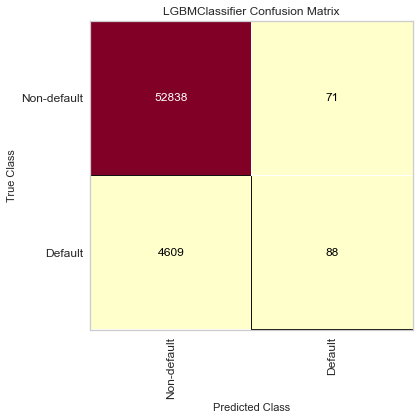

In [106]:
from yellowbrick.classifier import ConfusionMatrix
import matplotlib.pyplot as plt

mapping = {0:"Non-default", 1:"Default"}

fig, ax = plt.subplots(figsize=(6, 6))

cm_viz = ConfusionMatrix(
    pipe,
    classes=["Non-default", "Default"],
    label_encoder=mapping,
)
cm_viz.score(X_eval, y_eval)
cm_viz.poof()

fig.savefig("plots/confusion_matrix.png", dpi=300)

## **Métrique "métier"**

In [108]:
# Scoring the the naïve baseline model
score = custom_scorer(baseline, X_eval, y_eval)
print("Score of the naïve model: Custom_metric = {:.4f}".format(score))

# Scoring the the selected model on training set
score_fit = custom_scorer(pipe, X_fit, y_fit)
print("Score of the selected model (on X_fit): Custom_metric = {:.4f}".format(score_fit))

# Scoring the the selected model on training set
score_eval = custom_scorer(pipe, X_eval, y_eval)
print("Score of the selected model (on X_eval): Custom_metric = {:.4f}".format(score_eval))

Score of the naïve model: Custom_metric = 0.0000
Score of the selected model (on X_fit): Custom_metric = 0.4306
Score of the selected model (on X_eval): Custom_metric = 0.3461


### **Sélection du seuil** (threshold)

In [ ]:
import numpy as np

scores = []
for threshold in np.linspace(0, 1, num=101):
    y_pred = predict_threshold(pipe, X_eval, threshold=threshold)
    score = custom_score(y_eval, y_pred)
    scores.append(score)

Max score: 0.31701085799446455
Optimal threshold: 0.58


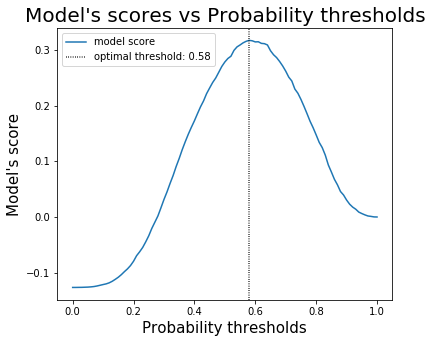

In [67]:
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(np.linspace(0, 1, num=101), scores, label="model score")

max_score = max(scores)
opt_threshold = np.linspace(0, 1, num=101)[scores.index(max_score)]

plt.axvline(x=opt_threshold, color='k', dashes=(0.5, 1), label="optimal threshold: {}".format(opt_threshold))

plt.title("Model's scores vs Probability thresholds", fontsize=20)
plt.xlabel("Probability thresholds", fontsize=15)
plt.ylabel("Model's score", fontsize=15)
plt.legend()

print("Max score:", max_score)
print("Optimal threshold:", opt_threshold)

fig.savefig("plots/scores_vs_thresholds.png", dpi=300)

# **SAUVEGARDE** du modèle
Nous ré-entraînons le modèle avec les les hyperparamètres sélectionnés, sur l'ensemble du jeu de données pour lequel nous disposons des étiquettes cibles : le jeu de données d'entraînement et le jeu de données de test.

Nous sauvegardons le modèle dans un fichier pickle pour usage ultérieur, en indiquant dans le nom du fichier la version de scikit-learn.

## Ré-entraînement final

In [68]:
# Load libraries
import sklearn
import joblib
from sklearn.impute import SimpleImputer

# Split features and targets
X = train.drop(columns='TARGET')
y = train['TARGET']

# Imputations
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(X)
X = pd.DataFrame(imp_mean.transform(X), columns=feature_names)

# Re-training the final model on the whole set
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocess',
                 Pipeline(memory=None,
                          steps=[('scale',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True))],
                          verbose=False)),
                ('model',
                 LogisticRegression(C=1.4558156014201493,
                                    class_weight='balanced', dual=False,
                                    fit_intercept=False, intercept_scaling=1,
                                    l1_ratio=None, max_iter=893,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear',
                                    tol=1.9622032740150946e-05, verbose=0,
                                    warm_start=True))],
         verbose=False)

## Sauvegarde du modèle

In [69]:
# Get scikit-learn version
scikit_version = sklearn.__version__

# Save the models for GHG and SiteEnergyUse as pickle files
joblib.dump(pipe, "models/model_{version}.pkl".format(version=scikit_version))

['models/model_0.22.1.pkl']